# **Phase III: Machine Learning**
In this notebook we are aiming to create one regression model and one classification model for analysis.

## Importing Data, General Preprocessing and Feature Engineering 
We have written the needed data from the database to a `.csv` file for simple import/export. In this cell we import the data into our notebook and do some simple time preprocessing and feature engineering.

In [83]:
import pandas as pd 
import numpy as np

data = pd.read_csv("../data/MLdata.csv")

data["Ship Date"] = pd.to_datetime(data["Ship Date"])
data["Order Date"] = pd.to_datetime(data["Order Date"])

data["Price Per Unit"] = data["Sales"] / data["Quantity"]
data["Ship Delay"] = (data["Ship Date"] - data["Order Date"]).dt.days

data["Ship Date Day"] = data["Ship Date"].dt.dayofyear
data["Order Date Day"] = data["Order Date"].dt.dayofyear

data["Ship Date Month"] = data["Ship Date"].dt.month
data["Order Date Month"] = data["Order Date"].dt.month

data["Ship Date Absolute"] = data["Ship Date"].map(lambda x: x.toordinal())
data["Ship Date Absolute"] = data["Order Date"].map(lambda x: x.toordinal())

data.head()

,Order Priority,Market,Segment,Category,Sub-Category,City,Country,Region,State,Ship Date,...,Shipping Cost,Ship Mode,Profit,Price Per Unit,Ship Delay,Ship Date Day,Order Date Day,Ship Date Month,Order Date Month,Ship Date Absolute
0,Critical,US,Consumer,Technology,Accessories,New York City,United States,East,New York,2012-07-31,...,933.57,Same Day,762.1850,329.950000,0,213,213,7,7,734715
1,Critical,US,Consumer,Furniture,Tables,New York City,United States,East,New York,2012-07-31,...,348.18,Same Day,-290.8750,155.825714,0,213,213,7,7,734715
2,Critical,US,Consumer,Office Supplies,Paper,New York City,United States,East,New York,2012-07-31,...,7.24,Same Day,9.3312,6.480000,0,213,213,7,7,734715
3,Critical,APAC,Corporate,Technology,Copiers,Wollongong,Australia,Oceania,New South Wales,2013-02-07,...,65.35,Second Class,34.4220,172.341000,2,38,36,2,2,734904
4,Critical,APAC,Corporate,Office Supplies,Storage,Wollongong,Australia,Oceania,New South Wales,2013-02-07,...,41.64,Second Class,-6.0300,26.784000,2,38,36,2,2,734904


## **Regression Model**
Copying data from our main source dataframe and splitting it into train/test splits.

In [4]:
from sklearn.model_selection import train_test_split

dfp = data.copy()
dfp = dfp.drop(["Ship Date", "Order Date"], axis=1)

# Reordering Columns
dfp = dfp[['Order Priority', 'Market', 'Segment', 'Category', 'Sub-Category',
         'Region', 'Quantity',
         'Discount', 'Shipping Cost', 'Ship Delay', 'Ship Date Day',
         'Order Date Day', 'Ship Date Month', 'Order Date Month',
         'Ship Date Absolute', "Sales","Price Per Unit", 'Ship Mode', 'Profit']]

x_profit = dfp.drop(["Profit"], axis=1)
y_profit = dfp["Profit"]

xp_train, xp_test, yp_train, yp_test = train_test_split(x_profit, y_profit, test_size=0.2, random_state=42)

,Order Priority,Market,Segment,Category,Sub-Category,Region,Quantity,Discount,Shipping Cost,Ship Delay,Ship Date Day,Order Date Day,Ship Date Month,Order Date Month,Ship Date Absolute,Sales,Price Per Unit,Ship Mode,Profit
0,Critical,US,Consumer,Technology,Accessories,East,7,0.0,933.57,0,213,213,7,7,734715,2309.650,329.950000,Same Day,762.1850
1,Critical,US,Consumer,Furniture,Tables,East,7,0.4,348.18,0,213,213,7,7,734715,1090.780,155.825714,Same Day,-290.8750
2,Critical,US,Consumer,Office Supplies,Paper,East,3,0.0,7.24,0,213,213,7,7,734715,19.440,6.480000,Same Day,9.3312
3,Critical,APAC,Corporate,Technology,Copiers,Oceania,2,0.1,65.35,2,38,36,2,2,734904,344.682,172.341000,Second Class,34.4220
4,Critical,APAC,Corporate,Office Supplies,Storage,Oceania,5,0.1,41.64,2,38,36,2,2,734904,133.920,26.784000,Second Class,-6.0300


### Training
Here we used Random Forest Regressor for our regression analysis. We have also limited some of our features by analyzing feature importances post training. Using Gridsearch and cross validation we are aiming to obtain the best params.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

ctp = ColumnTransformer([
    ("encoder", TargetEncoder(), ['Sub-Category']),
    ("scalar", StandardScaler(), ["Shipping Cost", "Sales", "Price Per Unit"]),
    ("passthorugh", 'passthrough', ["Discount"])
])

model_profit = Pipeline(steps=[
    ("ct", ctp),
    ("regressor", RandomForestRegressor(n_jobs=-1))
])

param_grid_profit = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [5, 10, 20, None], 
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4], 
    'regressor__max_features': [None, 'sqrt', 'log2']
}

grid_search_profit = GridSearchCV(estimator=model_profit, param_grid=param_grid_profit, cv=5, n_jobs=-1, verbose=1)
grid_search_profit.fit(xp_train, yp_train)
best_model_profit = grid_search_profit.best_estimator_

yp_pred = best_model_profit.predict(xp_test)

### Model Performace
Optimal Parameters are found and these are some metrics that show the model's performance.

In [109]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

profit_r2 = r2_score(yp_test, yp_pred)
profit_mse = mean_squared_error(yp_test, yp_pred)
profit_mae = mean_absolute_error(yp_test, yp_pred)
print(f"Best Hyperparameters: {grid_search_profit.best_params_}")
print(f"R2 score: {profit_r2}")
print(f"MSE: {profit_mse}")
print(f"MAE: {profit_mae}")

Best Hyperparameters: {'regressor__max_depth': 10, 'regressor__max_features': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}
R2 score: 0.7416523339546243
MSE: 6474.830732517554
MAE: 34.12495446667304


### Plots

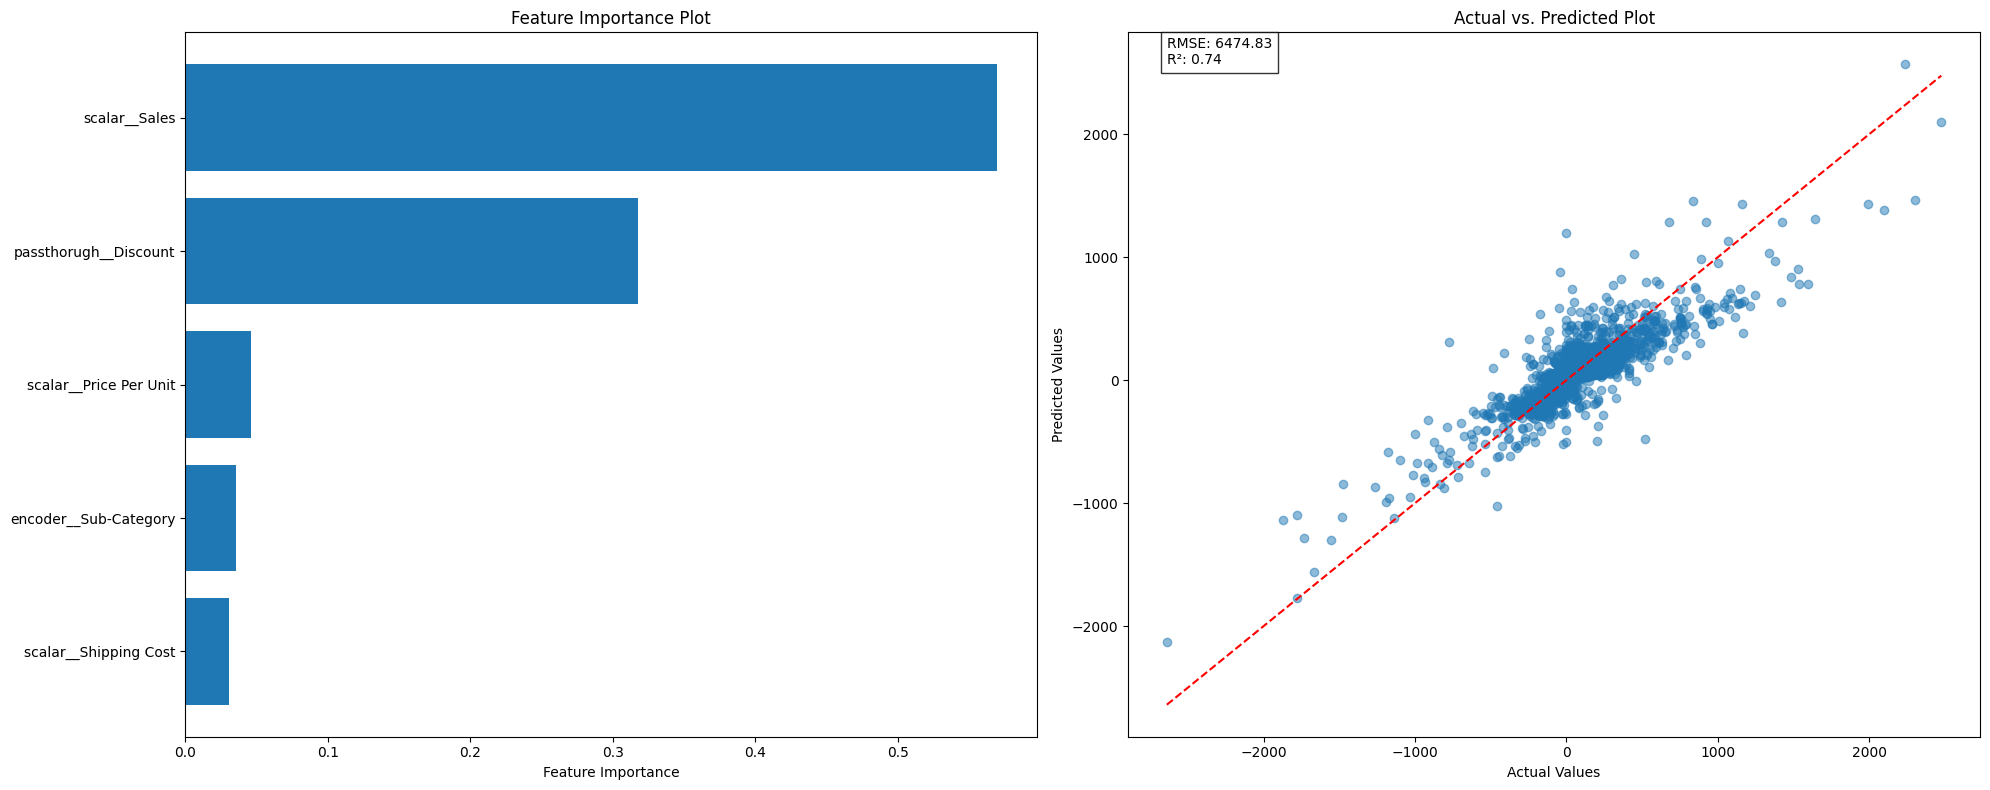

In [129]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score


# Feature Importance Plot
importance = model_profit.named_steps["regressor"].feature_importances_
features = model_profit.named_steps["ct"].get_feature_names_out()
feature_imp = pd.DataFrame(importance, features, columns=["Importance"])
feature_imp = feature_imp.sort_values("Importance", ascending=True)

plt.figure(figsize=(20, 8))

# Plot 1: Feature Importance
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.barh(feature_imp.index, feature_imp["Importance"])
plt.xlabel("Feature Importance")
plt.title("Feature Importance Plot")

# Plot 2: Actual vs. Predicted
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.scatter(yp_test, yp_pred, alpha=0.5)
plt.plot([min(yp_test), max(yp_test)], [min(yp_test), max(yp_test)], color='red', linestyle='--')  # Diagonal line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Plot")

# Add metrics to the plot (optional)
rmse = mean_squared_error(yp_test, yp_pred)
r2 = r2_score(yp_test, yp_pred)
plt.text(min(yp_test), max(yp_pred), f"RMSE: {rmse:.2f}\nR²: {r2:.2f}", fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# **Classification Model**

Copying data from our main source dataframe and splitting it into train/test splits.

In [106]:
from sklearn.model_selection import train_test_split

# Classifier Data
dfs = data.copy()
dfs = dfs[['Order Priority', 'Market', 'Segment', 'Category', 'Sub-Category', 'Region', 'City', 'Country', 'State',
           'Quantity', 'Discount', 'Sales', 'Shipping Cost', 'Profit',
           'Price Per Unit', 'Ship Delay', 'Ship Date Day', 'Order Date Day',
           'Ship Date Month', 'Order Date Month', 'Ship Date Absolute', 'Ship Mode']]
dfs.head()

x_shipping = dfs.drop(["Ship Mode"], axis=1)
y_shipping = dfp["Ship Mode"]

xs_train, xs_test, ys_train, ys_test = train_test_split(x_shipping, y_shipping, test_size=0.2, random_state=42)

### Model Training
We are using a Random Forest Classifier for this task and by using Gridsearch and cross validation we are aiming to obtain the best params.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

target_encoder = TargetEncoder()

encoded_train = target_encoder.fit_transform(xs_train[['City', 'Country', 'State']], ys_train)
encoded_test = target_encoder.transform(xs_test[['City', 'Country', 'State']])
encoded_train = pd.DataFrame(encoded_train, columns=target_encoder.get_feature_names_out())
encoded_test = pd.DataFrame(encoded_test, columns=target_encoder.get_feature_names_out())

xs_train = xs_train.drop(['City', 'Country', 'State'], axis=1)
xs_train = pd.concat([xs_train.reset_index(drop=True), encoded_train], axis=1)
xs_test = xs_test.drop(['City', 'Country', 'State'], axis=1)
xs_test = pd.concat([xs_test.reset_index(drop=True), encoded_test], axis=1)

ordinal_features = ['Order Priority', 'Market', 'Segment', 'Category', 'Sub-Category', 'Region']
scalar_features = ['Sales', 'Profit', 'Price Per Unit']
passthrough_features =  np.append(target_encoder.get_feature_names_out(),["Discount", "Quantity", 'Order Date Day', 'Order Date Month'])

cts = ColumnTransformer([
    ("ordinal", OrdinalEncoder(), ordinal_features),
    ("scalar", StandardScaler(), scalar_features),
    ("passthorugh", 'passthrough', passthrough_features)
])

model_shipping = Pipeline(steps=[
    ("ct", cts),
    ("classifier", RandomForestClassifier(n_jobs=-1, n_estimators=400))
])

param_grid_ship = {
    'classifier__n_estimators': [50, 100, 200], 
    'classifier__max_depth': [5, 10, 20, None], 
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],  
    'classifier__max_features': [None, 'sqrt', 'log2']
}

grid_search_ship = GridSearchCV(estimator=model_shipping, param_grid=param_grid_ship, cv=5, n_jobs=-1, verbose=1)

grid_search_ship.fit(xs_train, ys_train)
best_model_ship = grid_search_ship.best_estimator_
ys_pred = best_model_ship.predict(xs_test)



### **Model Performance**
Using GridSearch we managed to obtain the best hyperparameters, Here are some key metrics to show the model's performance: 

In [97]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

f1_shipping = f1_score(ys_test, ys_pred, average='weighted')
accuracy_shipping = accuracy_score(ys_test, ys_pred)
recall_shipping = recall_score(ys_test, ys_pred, average='weighted')
precision_shipping = precision_score(ys_test, ys_pred, average='weighted')

print(f"Best Parameters: {grid_search_ship.best_params_}")
print(f"F1 score: {f1_shipping}")
print(f"Accuracy score: {accuracy_shipping}")
print(f"Recall score: {recall_shipping}")
print(f"Precision score: {precision_shipping}")

Best Parameters: {'classifier__max_depth': None, 'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
F1 score: 0.6631498888172209
Accuracy score: 0.6990134890275821
Recall score: 0.6990134890275821
Precision score: 0.6776174846179743


### Plots

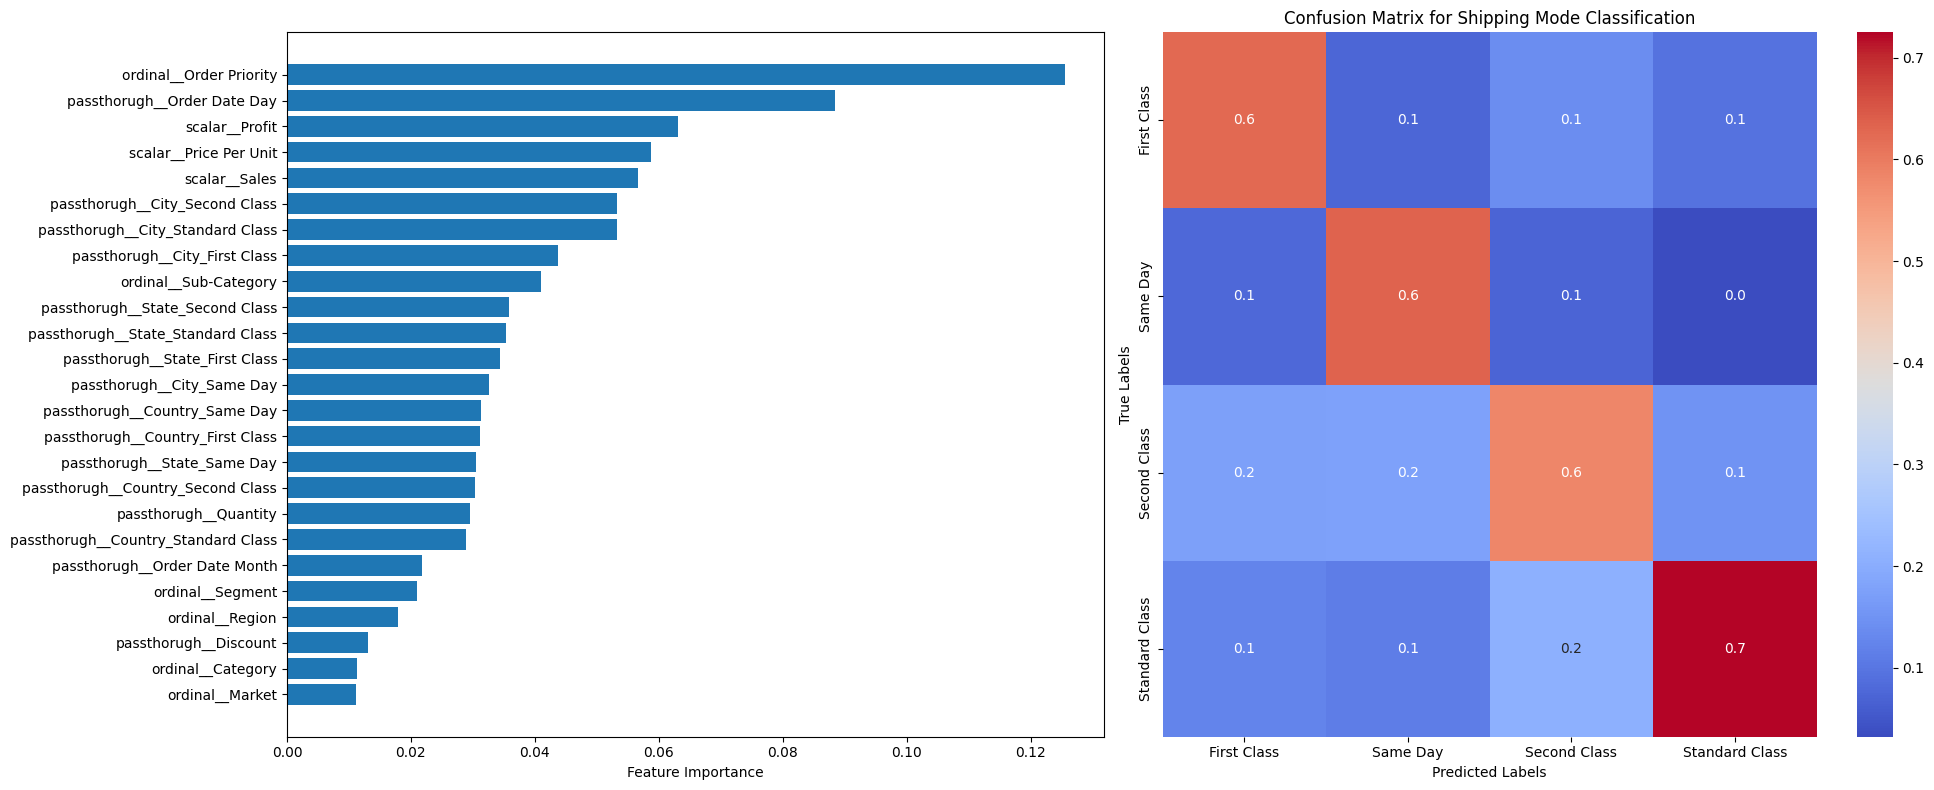

In [128]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = best_model_ship.classes_
confusion_shipping = confusion_matrix(ys_test, ys_pred, normalize='pred')

plt.figure(figsize=(20, 8))
plt.subplot(1,2,2)

sns.heatmap(confusion_shipping, annot=True, fmt= ".1f", cmap="coolwarm", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Shipping Mode Classification")

importance = best_model_ship.named_steps["classifier"].feature_importances_
features = best_model_ship.named_steps["ct"].get_feature_names_out()
feature_imp = pd.DataFrame(importance, features, columns=["Importance"])
feature_imp = feature_imp.sort_values("Importance", ascending=True)
plt.subplot(1,2,1)

plt.barh(feature_imp.index, feature_imp["Importance"])
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()